In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import pickle
import glob
import itertools
import pandas as pd
from utils.plot_util import *
import socket
import os

In [2]:
# to have TensorFlow start out using only a minimum amount of memory and then allocate more as needed
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# set up gpu to make sure one gpu can work for multiple scripts at the same time
os.environ["CUDA_VISIBLE_DEVICES"]="0" # use the first gpu
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


## Data Loading

In [3]:
hostname = socket.gethostname()
if hostname == 'HAITI' or 'Gorleben':
    DIR = "C:/Users/xin/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "D:/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'BALI':
    DIR = "/home/xin/projects/trelleborg"
    DATASET = "/storage/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'LAPTOP-1FOJITEG':
    DIR = "C:/Users/xinch/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "C:/LINHC/VersucheDBs/Trelleborg/V27/*.h5"
DIR = os.path.abspath(DIR)
DATASET = os.path.abspath(DATASET)
SAVED_IN = os.path.abspath( DIR + "/models/V27/autoencoder/")
Path(SAVED_IN).mkdir(parents=True, exist_ok=True)

file_list = []
for file in glob.glob(DATASET):
    file_list.append(file)
file_list = sorted(file_list)
file_list_LEM1 = [file for file in file_list if 'LEM1' in file]
file_list_LEM1

['D:\\xin\\datasets\\Trelleborg\\V27\\V27-100bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-200bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-30bar_LEM1.h5']

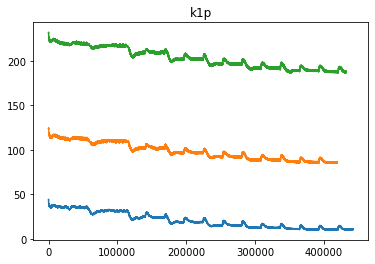

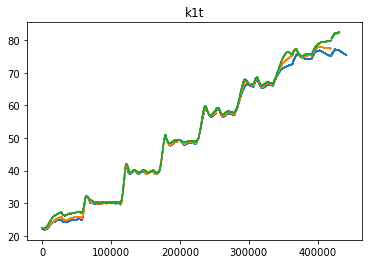

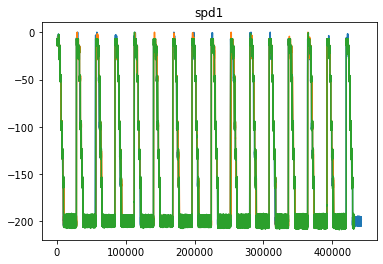

In [4]:
# load raw data and shifts
h5_p30 = h5py.File(file_list_LEM1[2], "r")
filename_p30 = file_list_LEM1[2].split(os.sep)[-1][:-3]
pklName_p30 = DIR + '/data/V27/shift_opts_freqs_all/' + filename_p30 + '.pkl'
shift_opts_freqs_all_p30 = pickle.load(open(pklName_p30, 'rb')) 

h5_p100 = h5py.File(file_list_LEM1[0], "r")
filename_p100 = file_list_LEM1[0].split(os.sep)[-1][:-3]
pklName_p100 = DIR + '/data/V27/shift_opts_freqs_all/' + filename_p100 + '.pkl'
shift_opts_freqs_all_p100 = pickle.load(open(pklName_p100, 'rb')) 

h5_p200 = h5py.File(file_list_LEM1[1], "r")
filename_p200 = file_list_LEM1[1].split(os.sep)[-1][:-3]
pklName_p200 = DIR + '/data/V27/shift_opts_freqs_all/' + filename_p200 + '.pkl'
shift_opts_freqs_all_p200 = pickle.load(open(pklName_p200, 'rb')) 


def plot3(h51,h52,h53,key):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(key)
    ax.plot(h51[key])
    ax.plot(h52[key])
    ax.plot(h53[key])
plot3(h5_p30,h5_p100,h5_p200,'k1p')
plot3(h5_p30,h5_p100,h5_p200,'k1t')
plot3(h5_p30,h5_p100,h5_p200,'spd1')

## Data Extraction

In [5]:
N = 100 # ignore first N points to make the shift possible

spd_p30 = np.round(h5_p30['spd1'][N:],decimals=1)
spd_p100 = np.round(h5_p100['spd1'][N:],decimals=1)
spd_p200 = np.round(h5_p200['spd1'][N:],decimals=1)

pos_p30 = np.round(h5_p30['pos1'][N:],decimals=1)
pos_p100 = np.round(h5_p100['pos1'][N:],decimals=1)
pos_p200 = np.round(h5_p200['pos1'][N:],decimals=1)

k1t_p30 = np.round(h5_p30['k1t'][N:],decimals=1)
k1t_p100 = np.round(h5_p100['k1t'][N:],decimals=1)
k1t_p200 = np.round(h5_p200['k1t'][N:],decimals=1)

ip1k1_p30 = np.round(h5_p30['ip1k1'][N:],decimals=1)
ip1k1_p100 = np.round(h5_p100['ip1k1'][N:],decimals=1)
ip1k1_p200 = np.round(h5_p200['ip1k1'][N:],decimals=1)

len_p30 =pos_p30.shape[0]
len_p100 =pos_p100.shape[0]
len_p200 =pos_p200.shape[0]

print("length:")
print(len_p30)
print(len_p100)
print(len_p100)
print("max:")
print(max(pos_p30))
print(max(pos_p100))
print(max(pos_p200))
print("min:")
print(min(pos_p30))
print(min(pos_p100))
print(min(pos_p200))

length:
441946
419201
419201
max:
124.8
124.8
124.8
min:
-135.0
-134.9
-134.9


In [6]:
s21_p30 = np.array(h5_p30['S21_P1_LEM1'])
dataset_p30 = []
for j in range (121):
    index = np.arange(N,len(h5_p30['t'])) - shift_opts_freqs_all_p30[j,N:].round().astype(int)
    dataset_p30.append(s21_p30[index,j].real)
    dataset_p30.append(s21_p30[index,j].imag)
dataset_p30 = np.array(dataset_p30)

s21_p100 = np.array(h5_p100['S21_P1_LEM1'])
dataset_p100 = []
for j in range (121):
    index = np.arange(N,len(h5_p100['t'])) - shift_opts_freqs_all_p100[j,N:].round().astype(int)
    dataset_p100.append(s21_p100[index,j].real)
    dataset_p100.append(s21_p100[index,j].imag)
dataset_p100 = np.array(dataset_p100)

s21_p200 = np.array(h5_p200['S21_P1_LEM1'])
dataset_p200 = []
for j in range (121):
    index = np.arange(N,len(h5_p200['t'])) - shift_opts_freqs_all_p200[j,N:].round().astype(int)
    dataset_p200.append(s21_p200[index,j].real)
    dataset_p200.append(s21_p200[index,j].imag)
dataset_p200 = np.array(dataset_p200)

print(dataset_p30.shape)
print(dataset_p100.shape)
print(dataset_p200.shape)

(242, 441946)
(242, 419201)
(242, 431830)


In [7]:
h5_p30.close()
h5_p100.close()
h5_p200.close()

## Data Preprocessing for Autoencoder

**Pseudo code:**

for each specific position:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;find the indicies of themn in all three datasets and store the corresponding s21 as input of the autoencoder;

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;find the s21 with chamber pressure 100 bar and mean temperature (≈ 50℃) as the output of the autoencoder and store them;
    
    
    

In [8]:
MAX = min(max(pos_p30),max(pos_p100),max(pos_p200))
MIN = max(min(pos_p30),min(pos_p100),min(pos_p200))

In [9]:
# # test for a specific p
# p = 0
# ind_p30 = np.where(pos_p30==p)[0]
# ind_p100 = np.where(pos_p100==p)[0]
# ind_p200 = np.where(pos_p200==p)[0]
# L = ind_p30.shape[0] + ind_p100.shape[0] + ind_p200.shape[0]

# # indicies with chamber pressure 100 and temperature in the range of [48,52]
# ind_p100_t50 = np.where(np.logical_and(k1t_p100>=48, k1t_p100<=52))[0]

# # randomly choose one point as the ground choo
# gt = np.random.choice(np.intersect1d(ind_p100_t50,ind_p100))
    
# x_auto_ = np.concatenate((dataset_p30[:,ind_p30],dataset_p100[:,ind_p100],dataset_p200[:,ind_p200]),axis=1) # shape (242,L)
# y_auto_ = np.array(L * [dataset_p100[:,gt]]) # shape (L,242)


In [10]:
np.random.seed(42)
x_auto = []
y_auto = []

for p in np.arange(MIN,MAX+0.1,0.1):
    p = np.round(p,decimals=1)
    ind_p30 = np.where(pos_p30==p)[0]
    ind_p100 = np.where(pos_p100==p)[0]
    ind_p200 = np.where(pos_p200==p)[0]
    
    if ind_p30.size == 0:
        print("There is no data with position {} in dataset_p30".format(p))
        continue
    if ind_p100.size == 0:
        print("There is no data with position {} in dataset_p100".format(p))
        continue
    if ind_p200.size == 0:
        print("There is no data with position {} in dataset_p200".format(p))
        continue
        
    L = ind_p30.shape[0] + ind_p100.shape[0] + ind_p200.shape[0]
    
    try:
        # indicies with chamber pressure 100 and temperature in the range of [48,52]
        ind_p100_t50 = np.where(np.logical_and(k1t_p100>=48, k1t_p100<=52))[0]
    
        # randomly choose one point as the ground choo
        gt = np.random.choice(np.intersect1d(ind_p100_t50,ind_p100))
        
    except:
        print ("Search range of ground truth has to be extended for position {}".format(p))
        # indicies with chamber pressure 100 and temperature in the range of [45,55]
        ind_p100_t50 = np.where(np.logical_and(k1t_p100>=45, k1t_p100<=55))[0]
        # randomly choose one point as the ground choo
        gt = np.random.choice(np.intersect1d(ind_p100_t50,ind_p100))
        print ("We have to use the temperature {} instead\n".format(k1t_p100[gt]))
        
    x_auto_ = np.concatenate((dataset_p30[:,ind_p30],dataset_p100[:,ind_p100],dataset_p200[:,ind_p200]),axis=1) # shape (242,L)
    y_auto_ = np.array(L * [dataset_p100[:,gt]]) # shape (L,242)
    
    x_auto.append(x_auto_.T)
    y_auto.append(y_auto_)
    
x_auto = np.vstack(x_auto)
y_auto = np.vstack(y_auto)

print("shapes")
print(x_auto.shape)
print(y_auto.shape)

Search range of ground truth has to be extended for position -23.2
We have to use the temperature 52.6 instead

Search range of ground truth has to be extended for position -19.3
We have to use the temperature 47.6 instead

shapes
(1292976, 242)
(1292976, 242)


In [11]:
# result dictionary
d = {
    "abs":[
            np.mean(abs(x_auto)),
            np.mean(abs(y_auto))],

    "std":[
            np.std(abs(x_auto)),
            np.std(abs(y_auto))],
}
pd.DataFrame.from_dict(d, orient='index',
                       columns=['All', 'Ground Truth'])

,All,Ground Truth
abs,0.119339,0.116808
std,0.096906,0.092123


In [12]:
mae = losses.MeanAbsoluteError()(x_auto,y_auto).numpy()
print("Original MAE: {}".format(mae))
print("Mean relativ error: {0:.0%}".format(mae/d["abs"][0]))

Original MAE: 0.032709043473005295
Mean relativ error: 27%


### Train test split

In [13]:
from sklearn.model_selection import train_test_split

x_auto_train, x_auto_test, y_auto_train, y_auto_test,= train_test_split(x_auto, y_auto, test_size=0.2, random_state=42)

print(x_auto_train.shape)
print(x_auto_test.shape)

(1034380, 242)
(258596, 242)


### Normalize the data to [0,1]

mean, max, min based on x_auto_train or y_auto_train?

In [14]:
min_val = tf.reduce_min(x_auto_train)
max_val = tf.reduce_max(x_auto_train)

x_auto_train = (x_auto_train - min_val) / (max_val - min_val)
x_auto_test = (x_auto_test - min_val) / (max_val - min_val)
y_auto_train = (y_auto_train - min_val) / (max_val - min_val)
y_auto_test = (y_auto_test - min_val) / (max_val - min_val)

x_auto_train = tf.cast(x_auto_train, tf.float32)
x_auto_test = tf.cast(x_auto_test, tf.float32)
y_auto_train = tf.cast(y_auto_train, tf.float32)
y_auto_test = tf.cast(y_auto_test, tf.float32)

## Autoencoder

In [15]:
MODEL_NAME = "autoencoder_nc" 

In [16]:
## TODO
class AutoEncoder_NoCompression(Model):
  def __init__(self):
    super(AutoEncoder_NoCompression, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(242, activation="relu"),
      # layers.Dense(64, activation="relu"),
      layers.Dense(242, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(242, activation="relu"),
      # layers.Dense(128, activation="relu"),
      layers.Dense(242, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

autoencoder = AutoEncoder_NoCompression()

autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(
                            x_auto_train,
                            y_auto_train, 
                            epochs=20, 
                            batch_size=512,
                            validation_data=(x_auto_test, y_auto_test),
                            callbacks=[callback],
                            shuffle=True,
                            verbose=0
)

In [18]:
# autoencoder.save(os.path.join(SAVED_IN, MODEL_NAME))

In [19]:
# MODEL_NAME = "autoencoder_nc" 
# autoencoder = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

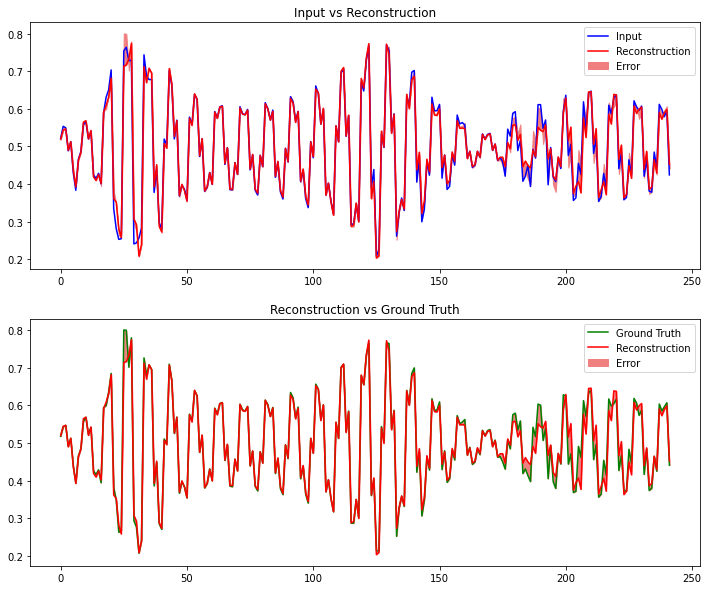

In [20]:
SAMPLE = 35138

encoded_imgs = autoencoder.encoder(x_auto_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

# plot the 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,10))

ax1.set_title("Input vs Reconstruction")
ax1.plot(x_auto_test[SAMPLE], 'b')
ax1.plot(decoded_imgs[SAMPLE], 'r')
ax1.fill_between(np.arange(242), decoded_imgs[SAMPLE], y_auto_test[SAMPLE], color='lightcoral')
ax1.legend(labels=["Input", "Reconstruction", "Error"])

ax2.set_title("Reconstruction vs Ground Truth")
ax2.plot(y_auto_test[SAMPLE], 'g')
ax2.plot(decoded_imgs[SAMPLE], 'r')
ax2.fill_between(np.arange(242), decoded_imgs[SAMPLE], y_auto_test[SAMPLE], color='lightcoral')
ax2.legend(labels=["Ground Truth", "Reconstruction", "Error"])


## Data Preprocessing for NN Training based on encoded imgs

In [21]:
GT = ['pos1','ip1k1']

### Encoding

In [22]:
X = np.concatenate((dataset_p30.T,dataset_p100.T,dataset_p200.T))
y1 = np.concatenate((pos_p30,pos_p100,pos_p200))
y2 = np.concatenate((ip1k1_p30,ip1k1_p100,ip1k1_p200))
y = np.array([y1,y2]).T

print(X.shape)
print(y.shape)

(1292977, 242)
(1292977, 2)


In [23]:
# MODEL_NAME = "autoencoder_nc" 
# autoencoder = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [24]:
# use the same normalization for autoencoder
min_val = tf.reduce_min(x_auto_train)
max_val = tf.reduce_max(x_auto_train)
X_norm = (X - min_val) / (max_val - min_val)

# encoding
X_encoded = autoencoder.encoder(X_norm).numpy()
X_encoded.shape

(1292977, 242)

### End stroke

In [25]:
#  positions bigger or smaller than 100 or 10 mm
p100 = np.where(y1>100)[0]
p10 = np.where(y1>10)[0]
n100 = np.where(y1<-100)[0]
n10 = np.where(y1<-10)[0]

#  positions within in or outside absolute value 100 or 10 mm
pos_in_100 = np.array(list(set(np.arange(y1.shape[0]))-(set(p100)|set(n100))))
pos_out_100 =  np.sort(np.concatenate((p100,n100)))
pos_in_10 = np.array(list(set(np.arange(y1.shape[0]))-(set(p10)|set(n10))))
pos_out_10 =  np.sort(np.concatenate((p10,n10)))

### Train test split wit indicies

In [26]:
from sklearn.model_selection import train_test_split

indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X_encoded, y, indices, test_size=0.2, random_state=42)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1034381, 242)
(1034381, 2)
(258596, 242)
(258596, 2)


Normalization for NN will be done in model construction phase

## NN Training based on encoded imgs

### 4-hidden-layer NN Model

In [27]:
MODEL_NAME = "NN_nc"

In [28]:
# TODO
def NN_nc(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(128, kernel_initializer='normal',activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(32, kernel_initializer='normal',activation='relu'),
      layers.Dense(2,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [29]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN = NN_nc(normalizer)
NN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 242)               485       
_________________________________________________________________
dense_4 (Dense)              (None, 128)               31104     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 58,503
Trainable params: 58,018
Non-trainable params: 485
________________________________________________

In [30]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 256,
    validation_split = 0.125,
    verbose=0, epochs=50)

Wall time: 6min 19s


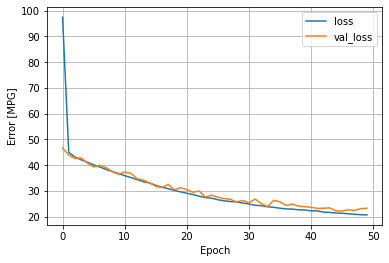

In [31]:
plot_loss(history)

In [32]:
# NN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\autoencoder\NN_exp\assets


In [33]:
# MODEL_NAME = "NN_nc"
# NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [34]:
# evaluation on both training and test sets

y_ = NN.predict(X_encoded)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [35]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE of predictions on training set,MSE of predictions on test set
0,pos1,4.213809,4.511993
1,ip1k1,38.147217,41.792313


In [36]:
from sklearn.metrics import mean_squared_error
print ("Average MSE of the prediction on training set: ", mean_squared_error(y_train_,y[idx_train_sort]))
print ("Average MSE of the prediction on test set: ", mean_squared_error(y_test_,y[idx_test_sort]))

Average MSE of the prediction on training set:  21.180512716128426
Average MSE of the prediction on test set:  23.152152921304147


In [37]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = y[idx_test_sort] - y_test_
err_in_100 = y[idx_in_100] - y_[idx_in_100]
err_out_100 = y[idx_out_100] - y_[idx_out_100]
err_in_10 = y[idx_in_10] - y_[idx_in_10]
err_out_10 = y[idx_out_10] - y_[idx_out_10]
err_p100 = y[idx_p100] - y_[idx_p100]
err_n100 = y[idx_n100] - y_[idx_n100]
err_p10 = y[idx_p10] - y_[idx_p10]
err_n10 = y[idx_n10] - y_[idx_n10]

In [38]:
# Evaluation of position predictions on end stroke in test set
OUTPUT = 0 # position

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:,OUTPUT])),
             np.mean(np.square(err_in_100[:,OUTPUT])),
             np.mean(np.square(err_out_100[:,OUTPUT])),
             np.mean(np.square(err_in_10[:,OUTPUT])),
             np.mean(np.square(err_out_10[:,OUTPUT])),
             np.mean(np.square(err_p100[:,OUTPUT])),
             np.mean(np.square(err_n100[:,OUTPUT])),
             np.mean(np.square(err_p10[:,OUTPUT])),
             np.mean(np.square(err_n10[:,OUTPUT]))],
    
    'std of position predictions' : [np.std(err_test_set[:,OUTPUT]),
             np.std(err_in_100[:,OUTPUT]),
             np.std(err_out_100[:,OUTPUT]),
             np.std(err_in_10[:,OUTPUT]),
             np.std(err_out_10[:,OUTPUT]),
             np.std(err_p100[:,OUTPUT]),
             np.std(err_n100[:,OUTPUT]),
             np.std(err_p10[:,OUTPUT]),
             np.std(err_n10[:,OUTPUT])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,4.511993,2.120681
1,within 100,6.432866,2.534486
2,outside 100,2.099684,1.440948
3,within 10,7.529932,2.739746
4,outside 10,4.360222,2.083739
5,>100,1.617482,1.258076
6,<-100,2.583386,1.602867
7,>10,4.210552,2.049932
8,<-10,4.522346,2.118727


In [39]:
# Evaluation of intermediate seal pressure predictions on end stroke in test set
OUTPUT = 1 # ip1k1

err_dict_es_ip1k1 = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of ip1k1 predictions' : [np.mean(np.square(err_test_set[:,OUTPUT])),
             np.mean(np.square(err_in_100[:,OUTPUT])),
             np.mean(np.square(err_out_100[:,OUTPUT])),
             np.mean(np.square(err_in_10[:,OUTPUT])),
             np.mean(np.square(err_out_10[:,OUTPUT])),
             np.mean(np.square(err_p100[:,OUTPUT])),
             np.mean(np.square(err_n100[:,OUTPUT])),
             np.mean(np.square(err_p10[:,OUTPUT])),
             np.mean(np.square(err_n10[:,OUTPUT]))],
    
    'std of ip1k1 predictions' : [np.std(err_test_set[:,OUTPUT]),
             np.std(err_in_100[:,OUTPUT]),
             np.std(err_out_100[:,OUTPUT]),
             np.std(err_in_10[:,OUTPUT]),
             np.std(err_out_10[:,OUTPUT]),
             np.std(err_p100[:,OUTPUT]),
             np.std(err_n100[:,OUTPUT]),
             np.std(err_p10[:,OUTPUT]),
             np.std(err_n10[:,OUTPUT])]
}
df_es_ip1k1 = pd.DataFrame.from_dict(err_dict_es_ip1k1)
df_es_ip1k1.style.set_caption("Evaluation of intermediate-seal-pressure predictions on end stroke in test set")

,Positions,MSE of ip1k1 predictions,std of ip1k1 predictions
0,all test set,41.792313,6.462532
1,within 100,47.399830,6.879084
2,outside 100,34.750166,5.894867
3,within 10,38.801411,6.216213
4,outside 10,41.942724,6.474451
5,>100,32.861170,5.729797
6,<-100,36.645038,6.049193
7,>10,47.192264,6.868756
8,<-10,36.256396,6.017898


Predictions of Position


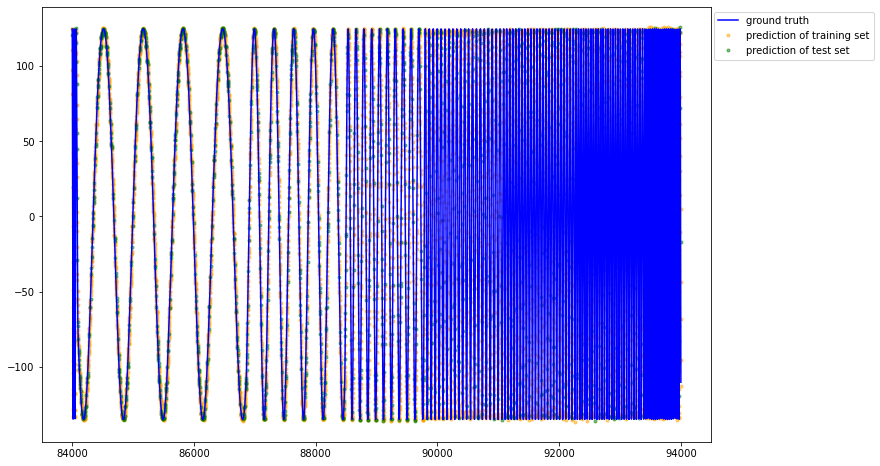

In [40]:
F = 84000
L = F+10000
print("Predictions of Position")
plot_one_gt_train_test(y[:,0],y_[:,0],idx_train_sort,idx_test_sort,F,L)

Prediction of Intermediate Seal Pressure


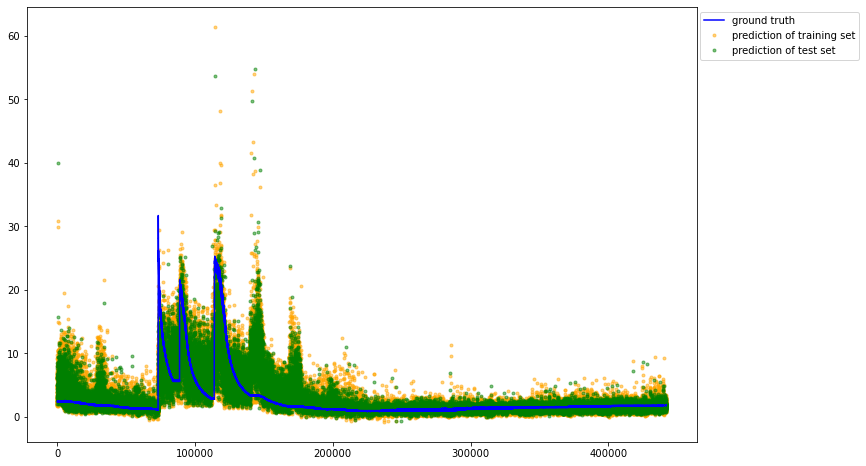

In [41]:
F = 0
L = len_p30
print("Prediction of Intermediate Seal Pressure")
plot_one_gt_train_test(y[:,1],y_[:,1],idx_train_sort,idx_test_sort,F,L)

Prediction of Intermediate Seal Pressure


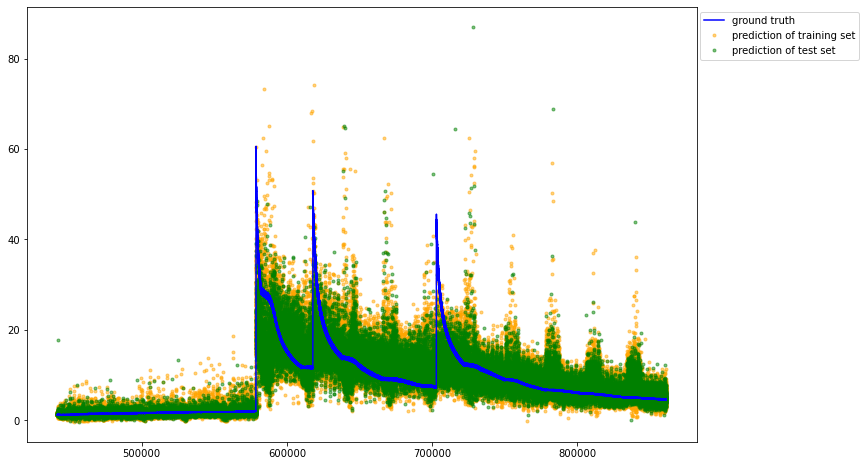

In [42]:
F = L
L = F + len_p100
print("Prediction of Intermediate Seal Pressure")
plot_one_gt_train_test(y[:,1],y_[:,1],idx_train_sort,idx_test_sort,F,L)

Prediction of Intermediate Seal Pressure


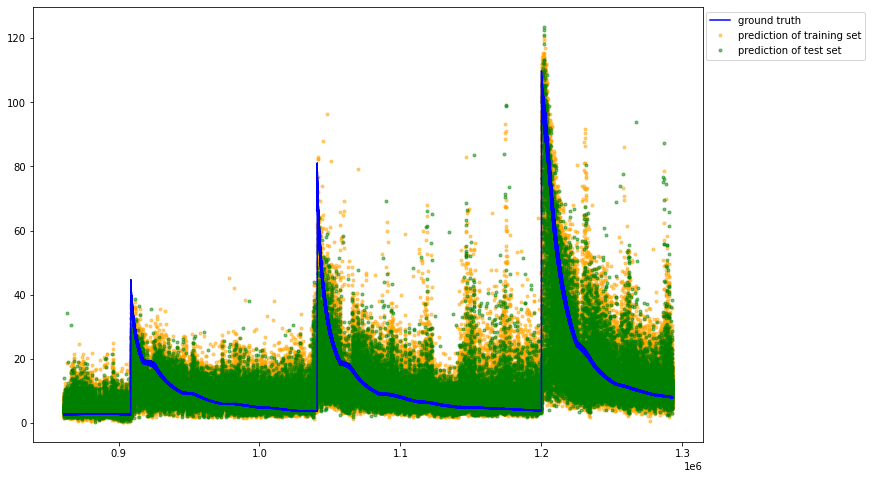

In [43]:
F = L
L = F + len_p200
print("Prediction of Intermediate Seal Pressure")
plot_one_gt_train_test(y[:,1],y_[:,1],idx_train_sort,idx_test_sort,F,L)

## NN Training without encoding (fro comparison)

### Train test split wit indicies

In [45]:
from sklearn.model_selection import train_test_split

indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, indices, test_size=0.2, random_state=42)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1034381, 242)
(1034381, 2)
(258596, 242)
(258596, 2)


### 4-hidden-layer NN Model

In [46]:
MODEL_NAME = "NN_nc"

In [47]:
# TODO
def NN_nc(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(128, kernel_initializer='normal',activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(32, kernel_initializer='normal',activation='relu'),
      layers.Dense(2,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [48]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
NN = NN_nc(normalizer)
NN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 242)               485       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               31104     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 66        
Total params: 58,503
Trainable params: 58,018
Non-trainable params: 485
________________________________________________

In [49]:
%%time
history = NN.fit(
    X_train, y_train, batch_size = 256,
    validation_split = 0.125,
    verbose=0, epochs=50)

Wall time: 6min 21s


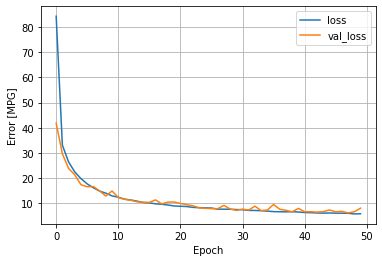

In [50]:
plot_loss(history)

In [51]:
# NN.save(os.path.join(SAVED_IN, MODEL_NAME))

In [52]:
# MODEL_NAME = "NN_nc"
# NN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [53]:
# evaluation on both training and test sets

y_ = NN.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [54]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE of predictions on training set,MSE of predictions on test set
0,pos1,2.144617,2.213399
1,ip1k1,12.517024,13.459861


In [55]:
from sklearn.metrics import mean_squared_error
print ("Average MSE of the prediction on training set: ", mean_squared_error(y_train_,y[idx_train_sort]))
print ("Average MSE of the prediction on test set: ", mean_squared_error(y_test_,y[idx_test_sort]))

Average MSE of the prediction on training set:  7.330820505798862
Average MSE of the prediction on test set:  7.836629857077265


In [56]:
# indicies of differnt sections
idx_in_100 = np.intersect1d(idx_test_sort,pos_in_100)
idx_out_100 = np.intersect1d(idx_test_sort,pos_out_100)
idx_in_10 = np.intersect1d(idx_test_sort,pos_in_10)
idx_out_10 = np.intersect1d(idx_test_sort,pos_out_10)
idx_p100 = np.intersect1d(idx_test_sort,p100)
idx_n100 = np.intersect1d(idx_test_sort,n100)
idx_p10 = np.intersect1d(idx_test_sort,p10)
idx_n10 = np.intersect1d(idx_test_sort,n10)

# errors of differnt sections
err_test_set = y[idx_test_sort] - y_test_
err_in_100 = y[idx_in_100] - y_[idx_in_100]
err_out_100 = y[idx_out_100] - y_[idx_out_100]
err_in_10 = y[idx_in_10] - y_[idx_in_10]
err_out_10 = y[idx_out_10] - y_[idx_out_10]
err_p100 = y[idx_p100] - y_[idx_p100]
err_n100 = y[idx_n100] - y_[idx_n100]
err_p10 = y[idx_p10] - y_[idx_p10]
err_n10 = y[idx_n10] - y_[idx_n10]

In [57]:
# Evaluation of position predictions on end stroke in test set
OUTPUT = 0 # position

err_dict_es_pos = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of position predictions' : [np.mean(np.square(err_test_set[:,OUTPUT])),
             np.mean(np.square(err_in_100[:,OUTPUT])),
             np.mean(np.square(err_out_100[:,OUTPUT])),
             np.mean(np.square(err_in_10[:,OUTPUT])),
             np.mean(np.square(err_out_10[:,OUTPUT])),
             np.mean(np.square(err_p100[:,OUTPUT])),
             np.mean(np.square(err_n100[:,OUTPUT])),
             np.mean(np.square(err_p10[:,OUTPUT])),
             np.mean(np.square(err_n10[:,OUTPUT]))],
    
    'std of position predictions' : [np.std(err_test_set[:,OUTPUT]),
             np.std(err_in_100[:,OUTPUT]),
             np.std(err_out_100[:,OUTPUT]),
             np.std(err_in_10[:,OUTPUT]),
             np.std(err_out_10[:,OUTPUT]),
             np.std(err_p100[:,OUTPUT]),
             np.std(err_n100[:,OUTPUT]),
             np.std(err_p10[:,OUTPUT]),
             np.std(err_n10[:,OUTPUT])]
}
df_es_pos = pd.DataFrame.from_dict(err_dict_es_pos)
df_es_pos.style.set_caption("Evaluation of position predictions on end stroke in test set")

,Positions,MSE of position predictions,std of position predictions
0,all test set,2.213399,1.452574
1,within 100,2.867106,1.633717
2,outside 100,1.392448,1.168206
3,within 10,3.217616,1.723567
4,outside 10,2.162897,1.437033
5,>100,1.131084,1.014297
6,<-100,1.654625,1.286258
7,>10,1.956870,1.336597
8,<-10,2.386067,1.531096


In [58]:
# Evaluation of intermediate seal pressure predictions on end stroke in test set
OUTPUT = 1 # ip1k1

err_dict_es_ip1k1 = {
    'Positions':['all test set','within 100', 'outside 100','within 10','outside 10','>100','<-100','>10','<-10'],
    
    'MSE of ip1k1 predictions' : [np.mean(np.square(err_test_set[:,OUTPUT])),
             np.mean(np.square(err_in_100[:,OUTPUT])),
             np.mean(np.square(err_out_100[:,OUTPUT])),
             np.mean(np.square(err_in_10[:,OUTPUT])),
             np.mean(np.square(err_out_10[:,OUTPUT])),
             np.mean(np.square(err_p100[:,OUTPUT])),
             np.mean(np.square(err_n100[:,OUTPUT])),
             np.mean(np.square(err_p10[:,OUTPUT])),
             np.mean(np.square(err_n10[:,OUTPUT]))],
    
    'std of ip1k1 predictions' : [np.std(err_test_set[:,OUTPUT]),
             np.std(err_in_100[:,OUTPUT]),
             np.std(err_out_100[:,OUTPUT]),
             np.std(err_in_10[:,OUTPUT]),
             np.std(err_out_10[:,OUTPUT]),
             np.std(err_p100[:,OUTPUT]),
             np.std(err_n100[:,OUTPUT]),
             np.std(err_p10[:,OUTPUT]),
             np.std(err_n10[:,OUTPUT])]
}
df_es_ip1k1 = pd.DataFrame.from_dict(err_dict_es_ip1k1)
df_es_ip1k1.style.set_caption("Evaluation of intermediate-seal-pressure predictions on end stroke in test set")

,Positions,MSE of ip1k1 predictions,std of ip1k1 predictions
0,all test set,13.459861,3.653811
1,within 100,12.301753,3.490314
2,outside 100,14.914259,3.849235
3,within 10,11.516833,3.369810
4,outside 10,13.557575,3.667477
5,>100,6.985225,2.634006
6,<-100,22.867955,4.764613
7,>10,9.686139,3.091022
8,<-10,17.751133,4.203293


Predictions of Position


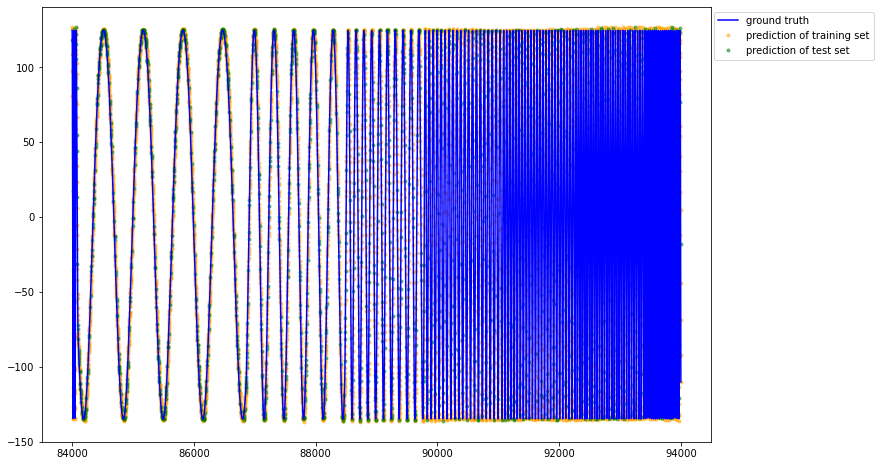

In [59]:
F = 84000
L = F+10000
print("Predictions of Position")
plot_one_gt_train_test(y[:,0],y_[:,0],idx_train_sort,idx_test_sort,F,L)

Prediction of Intermediate Seal Pressure


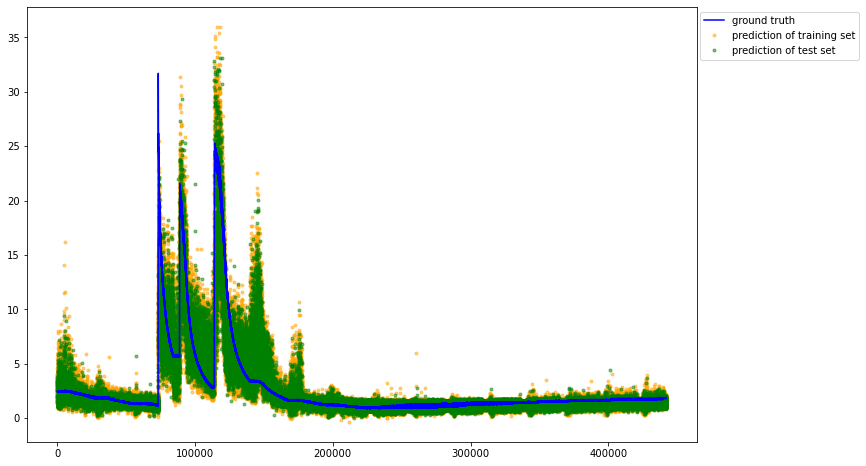

In [60]:
F = 0
L = len_p30
print("Prediction of Intermediate Seal Pressure")
plot_one_gt_train_test(y[:,1],y_[:,1],idx_train_sort,idx_test_sort,F,L)

Prediction of Intermediate Seal Pressure


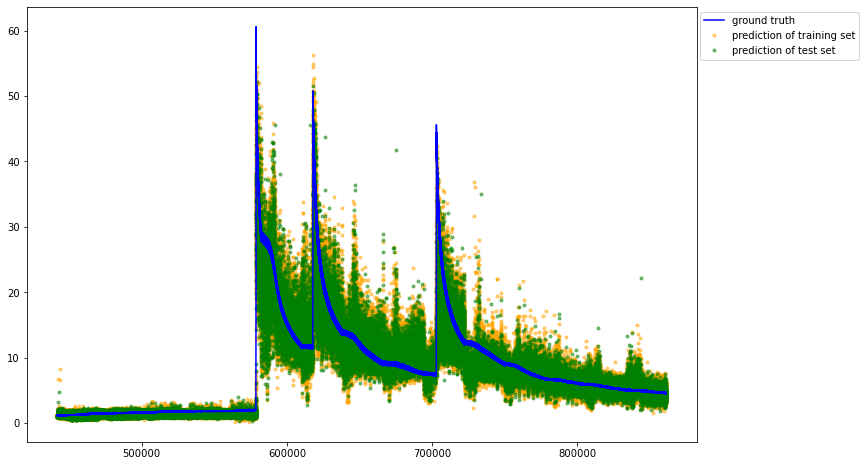

In [61]:
F = L
L = F + len_p100
print("Prediction of Intermediate Seal Pressure")
plot_one_gt_train_test(y[:,1],y_[:,1],idx_train_sort,idx_test_sort,F,L)

Prediction of Intermediate Seal Pressure


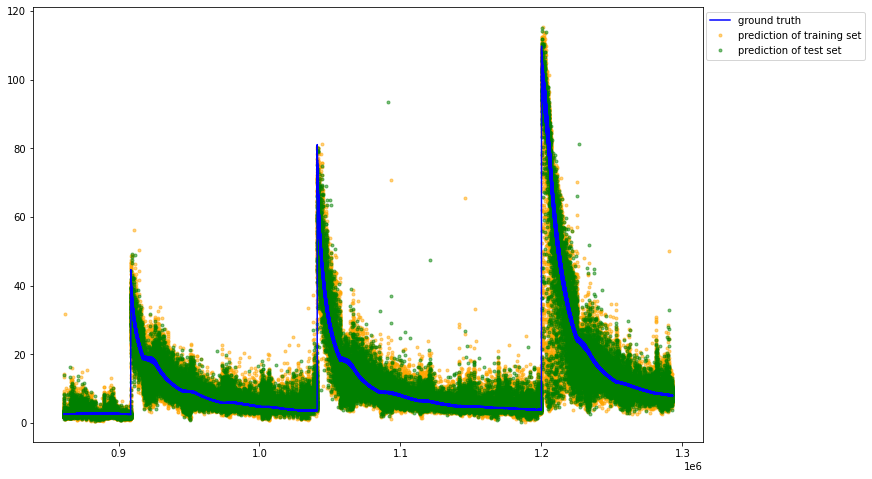

In [62]:
F = L
L = F + len_p200
print("Prediction of Intermediate Seal Pressure")
plot_one_gt_train_test(y[:,1],y_[:,1],idx_train_sort,idx_test_sort,F,L)